<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | MVP

# Diabetic Retinopathy<a id='top'></a> 

## **Analysis Goal**  
The client, ...

**RQ:** ...

## **Process**
**Data source:** 
...

**Models:** 
...


## **Preliminary Conclusions**
...


In [210]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import PIL
import seaborn as sns
import sklearn as sk
import warnings

%pylab inline
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
pd.set_option('display.max_colwidth', None)
sns.set(context='notebook', style='whitegrid')
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing import image as IMG
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import Sequential
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


# print("Matplotlib version:", plt.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print("Scikit-learn version:", sk.__version__)


Populating the interactive namespace from numpy and matplotlib
Numpy version: 1.21.6
Pandas version: 1.3.5
TensorFlow version: 2.8.2
Keras Version: 2.8.0
Scikit-learn version: 1.0.2


In [69]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sachinkumar413/diabetic-retinopathy-preprocessed-dataset)<a id='1'></a>  

Code adapted from [github/PurpleGrace](https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/1.EDA_Sample_Images.ipynb)


In [71]:
# dataset in Google Drive 

filepath = '/content/drive/MyDrive/Dataset'
filepath

'/content/drive/MyDrive/Dataset'

In [107]:
# read in files and store as dataframe

data = {'image_path':[],'diagnosis':[]}
print("List of diagnoses:")
for diagnosis in os.listdir(filepath):
    print(diagnosis)
    if diagnosis != 'Dataset':        
        for image in os.listdir(filepath +"/"+diagnosis):
            if image != 'Dataset':
                data['image_path'].append(filepath +"/"+diagnosis+"/"+ image)
                data['diagnosis'].append(diagnosis)
data = pd.DataFrame(data)  
print('Datatype:',type(data))  
data.head()


List of diagnoses:
Mild DR
Proliferative DR
No DR
Moderate DR
Severe DR
Datatype: <class 'pandas.core.frame.DataFrame'>


,image_path,diagnosis
0,/content/drive/MyDrive/Dataset/Mild DR/Mild DR_1236.jpg,Mild DR
1,/content/drive/MyDrive/Dataset/Mild DR/Mild DR_1521.jpg,Mild DR
2,/content/drive/MyDrive/Dataset/Mild DR/Mild DR_1140.jpg,Mild DR
3,/content/drive/MyDrive/Dataset/Mild DR/Mild DR_1682.jpg,Mild DR
4,/content/drive/MyDrive/Dataset/Mild DR/Mild DR_1480.jpg,Mild DR


## 2 | Exploratory Data Analysis<a id='2'></a>  

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11800 entries, 0 to 11799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  11800 non-null  object
 1   diagnosis   11800 non-null  object
dtypes: object(2)
memory usage: 184.5+ KB


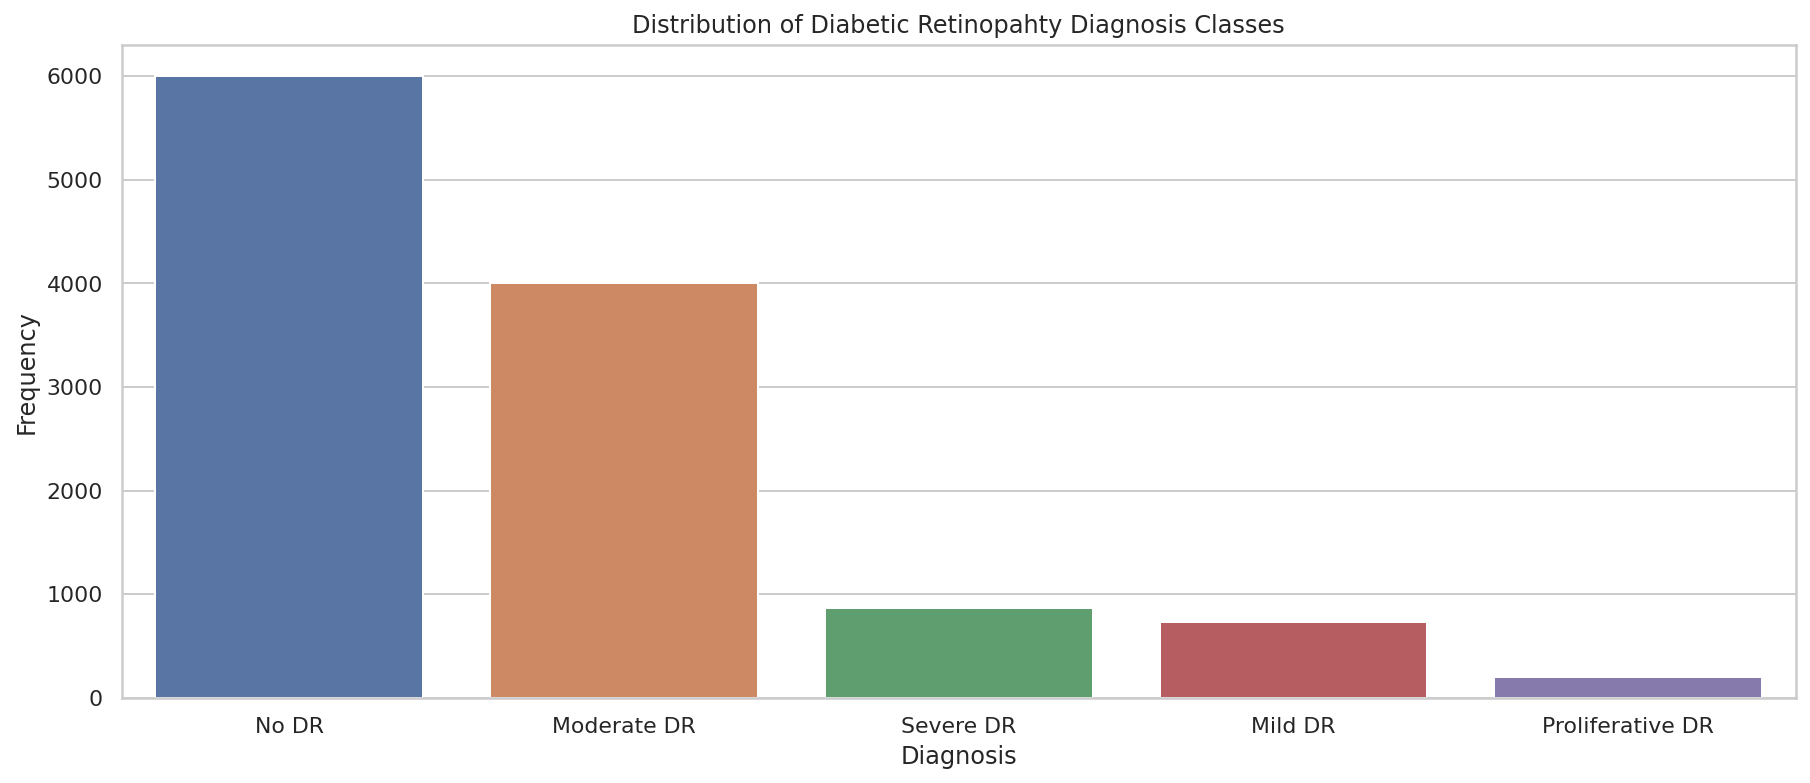

In [141]:
# distribution of diagnosis classes
plt.figure(figsize=(15,6))
sns.barplot(data.diagnosis.value_counts().index,
            data.diagnosis.value_counts(),
            palette=None)
plt.title("Distribution of Diabetic Retinopahty Diagnosis Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency");


In [ ]:
# show one healthy image

path = '/content/drive/MyDrive/Dataset/No DR/No DR.jpg'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
   target_size=(256, 256),
   interpolation="nearest")
print('No Diabetic Retinopthy')
print('Datatype:', type(healthy_image))
healthy_image 


In [ ]:
# show one severe DR image

path = '/content/drive/MyDrive/Dataset/Severe DR/Severe DR.jpg'

severe_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
   target_size=(256, 256), 
   interpolation="nearest")

print('Severe Diabetic Retinopthy')
print('Datatype:', type(severe_image))
severe_image 


### Preprocessing<a id='tp'></a>  

In [156]:
# read in all images as a tensor BatchDataset
# https://keras.io/api/preprocessing/image/

directory = '/content/drive/MyDrive/Dataset'
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False )

print('Datatype:', type(data), '\n')
data

Found 11800 files belonging to 5 classes.
Datatype: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 



<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [181]:
class_names = data.class_names
class_names

['Mild DR', 'Moderate DR', 'No DR', 'Proliferative DR', 'Severe DR']

In [189]:
for image_batch, labels_batch in data:
  print('image_batch.shape', image_batch.shape)
  print('labels_batch.shape', labels_batch.shape)
  break

image_batch.shape (32, 256, 256, 3)
labels_batch.shape (32,)


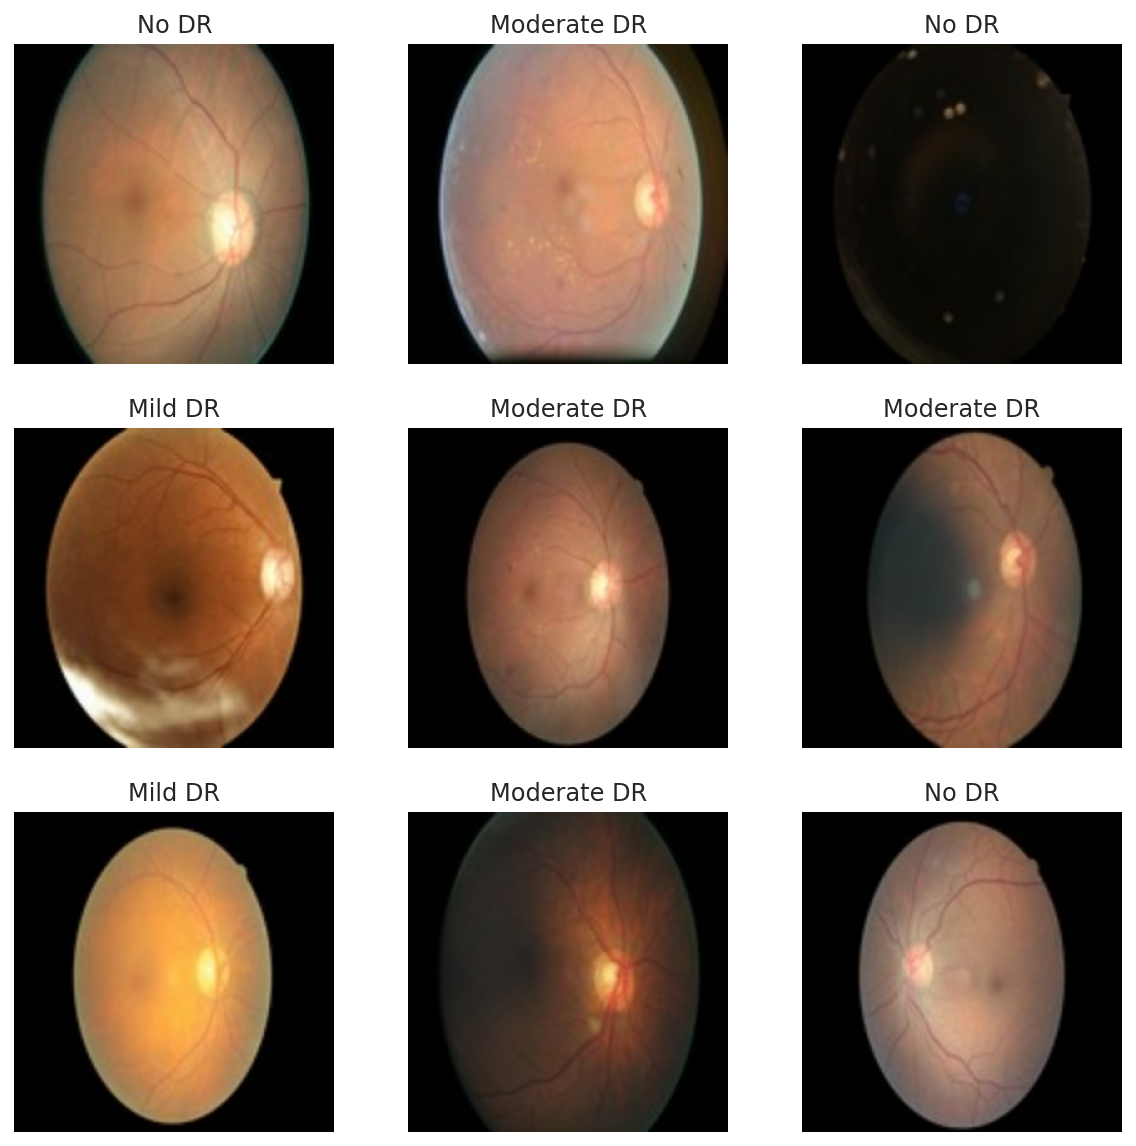

In [183]:
# show a sample of each diagnosis 

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset

# convert healthy_image to numpy array

img = healthy_image
healthy_image_array = tf.keras.preprocessing.image.img_to_array(img, 
                                                                data_format=None, 
                                                                dtype=None)
print('type:', type(healthy_image_array))
healthy_image_array

https://www.h5py.org/
https://www.tensorflow.org/tutorials/images/cnn
https://www.tensorflow.org/tutorials/images/classification
https://www.tensorflow.org/tutorials/images/transfer_learning

image_batch = tensor 32 images, sized 256x256, 3 RBG colors

In [ ]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=pb2Af2lsUShk

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model

In [ ]:
model.summary()

In [ ]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=pb2Af2lsUShk

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

After EDA, import images ...

https://www.h5py.org/
https://www.tensorflow.org/tutorials/images/cnn
https://www.tensorflow.org/tutorials/images/classification
https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in data:
  print('image_batch.shape', image_batch.shape)
  print('labels_batch.shape', labels_batch.shape)
  break

image_batch = tensor 32 images, sized 256x256, 3 RBG colors

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model

In [ ]:
model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# read in pickle
